In [9]:
def get_relevant_activations(data, markup_for_tag):
    result = []
    for i, tag in enumerate(markup_for_tag):
        if tag != 0:
            result.append(data[i])
    return np.stack(result)


def get_matches(activations, markup):
    markup = np.array(markup)
    markup_devs = markup - np.mean(markup)
    activation_devs = activations - np.mean(activations, 0, keepdims=True)
    activation_stddevs = np.std(activations, 0, ddof=1, keepdims=True)
    markup_stddev = np.std(markup, ddof=1)
    activation_dev_fractions = activation_devs / (activation_stddevs + 1e-20)
    markup_dev_fractions = markup_devs / (markup_stddev + 1e-20)
    return activation_dev_fractions * np.reshape(markup_dev_fractions, [-1, 1])


def compute_stats(data, markup_for_tag):
    markup_for_tag = np.array(markup_for_tag)
    stats = {}
    stats['markup'] = markup_for_tag
    stats['relevant_markup'] = list(filter(lambda x: x != 0, markup_for_tag))
    stats['relevant_activations'] = get_relevant_activations(data, markup_for_tag)
    stats['matches'] = get_matches(stats['relevant_activations'], stats['relevant_markup'])
    stats['correlations'] = np.mean(stats['matches'], 0)
    assert stats['correlations'].ndim == 1
    stats['match_stddevs'] = np.std(stats['matches'], 0)
    stats['mean_square_correlation'] = np.sqrt(np.mean(stats['correlations']**2))
    stats['meta'] = {
        "positive": np.count_nonzero(markup_for_tag == 1),
        "negative": np.count_nonzero(markup_for_tag == -1),
        "total": len(stats['markup']),
    }
    return stats

In [11]:
import os
import pickle
import numpy as np

os.makedirs('test', exist_ok=True)

with open("test/test.pickle", 'wb') as f:
    pickle.dump(np.array([[4]*10]*50), f)

In [12]:
! ls -l test

итого 8
-rw-rw-r-- 1 anton anton 4160 июн  7 11:29 test.pickle


In [5]:
import tensorflow as tf

def get_axis_quarters(tensor):
    last_dim = tf.shape(tensor, out_type=tf.float32)[-1]
    exponents = tf.range(0., last_dim, 1., dtype=tf.float32)
    powers = tf.math.pow(2., exponents)
    binary_format = tf.cast(tensor > 0, tf.float32)
    linear_combination = powers * binary_format
    numbers = tf.reduce_sum(linear_combination, axis=-1)
    return tf.cast(numbers, tf.int32)

tensor = tf.constant(
    [[1, -1, 1],
     [-1, -1, -1]]
)

axis_quarters = get_axis_quarters(tensor)

with tf.Session() as sess:
    print(sess.run(axis_quarters))

[5 0]


In [1]:
import pickle
import numpy as np

prefix = '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level1_1/NNS'

tmpl = os.path.join(prefix, '{}.pickle')

In [ ]:
file_name = tmpl.format('correlations')
with open(file_name, 'rb') as f:
    corr = pickle.load(f)
    
print(max(corr))
print(np.argmax(corr))

In [1]:
from collections import Counter
import numpy as np

a = np.array([1, 2, 3])

c = Counter(a)
print(c)

Counter({1: 1, 2: 1, 3: 1})


In [3]:
matches = tmpl.format('matches')
with open(matches, 'rb') as f:
    m = pickle.load(f)

m62 = m[:, 62]
print(m62)
print(max(m62))
print(np.argmax(m62))
print(min(m62))
print(np.argmin(m62))

[ 0.08246549  0.02131961  0.08308583 ... -0.55830922  0.02906624
  0.02100856]
18.750923953380248
50567
-13.644160917601068
52351


In [4]:
print(np.std(m62))

2.387342495802599


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

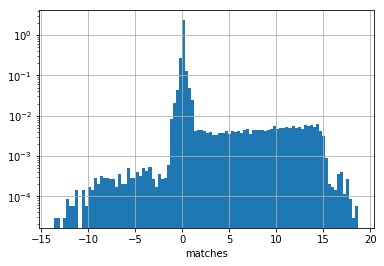

In [6]:
threshold = 0
f1 = m62[m62 > threshold]
f2 = m62[m62 <= -threshold]
filtered = np.concatenate([f1, f2])
plt.hist(filtered, bins=100, density=True)
plt.grid()
plt.yscale('log')
plt.xlabel('matches')

plt.show()

In [2]:
act = tmpl.format('relevant_activations')
with open(act, 'rb') as f:
    act = pickle.load(f)

In [3]:
markup = tmpl.format('relevant_markup')
with open(markup, 'rb') as f:
    markup = pickle.load(f)

In [4]:
act62 = act[:, 62]

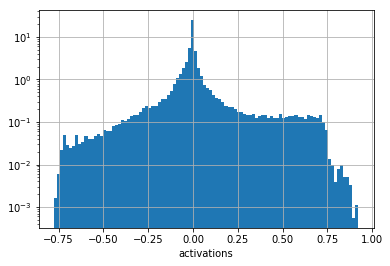

In [8]:

plt.hist(act62, bins=100, density=True)
plt.grid()
plt.yscale('log')
plt.xlabel('activations')

plt.show()

In [5]:
from helmo.util.plot.plot_helpers import density_plot

density_plot(m62, 0.001, None, 'blue')
plt.yscale('log')
plt.xlabel('matches')
plt.ylabel('density')
plt.grid()
plt.savefig(
    '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level1_1/NNS/plots/matches.png',
    dpi=900
)
plt.show()

NameError: name 'm62' is not defined

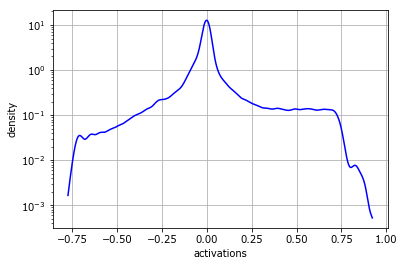

In [19]:
from helmo.util.plot.plot_helpers import density_plot

density_plot(act62, 0.0001, None, 'blue')
plt.yscale('log')
plt.xlabel('activations')
plt.ylabel('density')
plt.grid()
plt.savefig(
    '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level1_1/NNS/plots/activations.png',
    dpi=900
)
plt.show()

In [7]:
from helmo.util.plot.plot_helpers import density_plot

selected_indices = np.array(np.array(markup) + 1, dtype=bool)

In [8]:
nns_act62 = act62[selected_indices]

In [9]:
import numpy as np

print(nns_act62.shape)
print(nns_act62[:100])
min_ = np.min(act62)
max_ = np.max(act62)

(7996,)
[ 0.03987525  0.24359564  0.13936374  0.01275242  0.33905667  0.23092057
  0.49802893  0.7179312   0.6440741   0.72047305  0.68238884  0.27751622
  0.7226443   0.66829014  0.6769268   0.35996893  0.62734854  0.4216515
  0.53920376 -0.07121509  0.5742651   0.7341397   0.23616292  0.7350702
  0.13083465  0.35654765  0.5455406   0.41869763  0.5783358   0.61539644
  0.6135536   0.62634987  0.23542795  0.21027555  0.6333601   0.036227
  0.43719196  0.35494202  0.13239472  0.6450477   0.7428283   0.7066073
  0.6975089   0.28573078  0.42003262  0.20334533  0.45254168  0.40931424
  0.15804431  0.5475083   0.12762508  0.30116114  0.46461856  0.6587762
  0.34424582  0.47947675  0.7382973   0.43743163  0.48655224  0.3983338
  0.6633929   0.5986025   0.6500519   0.72113675  0.61620504  0.70613456
  0.02858962  0.5844811   0.5168905   0.2948563   0.41682157  0.40695137
  0.5016543   0.3709565   0.7006538   0.62645507 -0.00999689  0.631873
  0.37047824  0.10538723 -0.12101641  0.3286183   0.

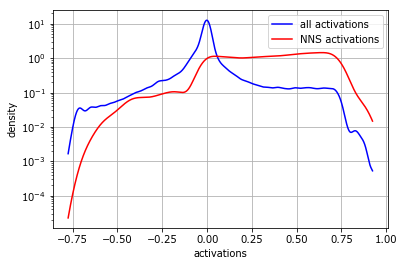

In [13]:
import os

import matplotlib.pyplot as plt

density_plot(act62, 0.0001, 'all activations', 'blue')
density_plot(nns_act62, 0.0001, 'NNS activations', 'red', [min_, max_])
plt.yscale('log')
plt.xlabel('activations')
plt.ylabel('density')
plt.grid()
plt.legend(loc='best')
plt.savefig(
    os.path.join(prefix, 'plots/activations_and_nns_activations.png'),
    dpi=900
)
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


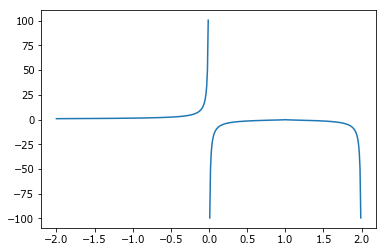

In [15]:
x = [0.01*i for i in range(-200, 200)]
y = [1 / np.log(abs(xx-1.)) for xx in x]

plt.plot(x, y)
plt.show()

In [171]:
! export PYTHONPATH="~/h-elmo:~/learning-to-learn"

In [173]:
! echo $PYTHONPATH

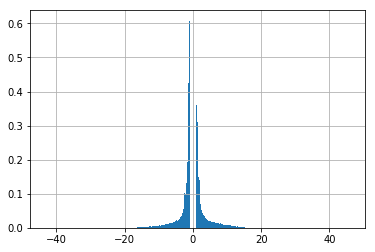

In [25]:
f1 = m[m > 1.]
f2 = m[m < -1.]
filtered = np.concatenate([f1, f2])
plt.hist(filtered, bins=1000, density=True)
plt.grid()
plt.show()

In [ ]:
tmpl = '/media/anton/DATA/results/h-elmo/expres/resrnn/poscorr/4/9/corr/level0_0/NNS/{}.pickle'
matches = tmpl.format('matches')
with open(matches, 'rb') as f:
    m = pickle.load(f)

In [ ]:
act = tmpl.format('activations')
with open(act, 'rb') as f:
    a = pickle.load(f)
    


In [ ]:
stddevs = tmpl.format('match_stddevs')
with open(stddevs, 'rb') as f:
    std = pickle.load(f)

print(std)
print(max(std))
print(np.argmax(std))

In [1]:
import tensorflow as tf


def get_all_values_except_specified(tensor, excluded):
    with tf.name_scope('get_all_values_except_specified'):
        tensor = tf.reshape(tensor, [-1])
        excluded = tf.reshape(excluded, [-1])
        excluded_shape = tf.shape(excluded)
        tensor_expanded = tf.reshape(tensor, [-1, 1])
        multiples = tf.concat([[1], excluded_shape], 0)
        tensor_expanded = tf.tile(tensor_expanded, multiples)
        masks = tf.cast(tf.equal(tf.cast(tensor_expanded, tf.int32), tf.cast(excluded, tf.int32)), tf.int32)
        mask = tf.reduce_sum(masks, [1])
        mask = tf.cast(tf.cast(mask, dtype=tf.bool), dtype=tf.int32) - 1
        return tf.boolean_mask(tensor, mask)
    

tensor, num_dims, axes, output = (
                    [[[1, 2], [3, 4]], [[5, 6], [7, 8]]],

                    5,

                    [0, 2, 4],

                    [[[[[1, 2]], [[3, 4]]], [[[5, 6]], [[7, 8]]]]],
                )

if not tf.contrib.framework.is_tensor(tensor):
    tensor = tf.constant(tensor)
if not tf.contrib.framework.is_tensor(axes):
    axes = tf.constant(axes, dtype=tf.int32)
sh = tf.shape(tensor, out_type=tf.int32)
nd = tf.shape(sh, out_type=tf.int32)[0]
assert_axes_smaller_than_num_dims = tf.assert_less(
    axes, num_dims, message='`axes` has to be less than `num_dims`')
check_num_dims = tf.assert_greater_equal(
    num_dims, nd,
    message='`num_dims` has to be greater or equal to number of dimensions in `tensor`'
)
ass_axes_bigger_or_equal_than_num_dims = tf.assert_greater_equal(axes, -num_dims)

negative_axes_mask = tf.cast(axes < 0, tf.int32)
axes += negative_axes_mask * num_dims

ones_for_expansion = tf.ones(tf.reshape(num_dims - nd, [1]), dtype=tf.int32)
shape_for_expansion = tf.concat([sh, ones_for_expansion], 0)

tensor = tf.reshape(tensor, shape_for_expansion)

# remained_axes = get_all_values_except_specified(tf.range(num_dims, dtype=tf.int32), axes)
# perm = tf.concat([axes, remained_axes], 0)
updates = tf.range(0, num_dims, 1, dtype=tf.int32)
remained_positions = get_all_values_except_specified(tf.range(num_dims, dtype=tf.int32), axes)
indices = tf.concat([axes, remained_positions], 0)
indices = tf.reshape(indices, [-1, 1])
perm_shape = tf.reshape(num_dims, [1])
perm = tf.scatter_nd(indices, updates, perm_shape)

with tf.control_dependencies([check_num_dims, assert_axes_smaller_than_num_dims, ass_axes_bigger_or_equal_than_num_dims]):
    tensor = tf.transpose(tensor, perm=perm)
    

with tf.Session() as sess:
    print(sess.run(tensor))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

[[[[[1 2]]

   [[3 4]]]]



 [[[[5 6]]

   [[7 8]]]]]


In [1]:
import numpy as np

from helmo.util.scripts.text_neuron_correlation import compute_stats

num_unrollings = 20
num_units = 4

# a = np.random.rand(num_units, num_unrollings)

m = np.random.choice([-1, 1, 0], num_unrollings)
a = np.stack([m]*num_units, 1)
print(a)

stats = compute_stats(a, m)
print(stats)

[[-1 -1 -1 -1]
 [ 1  1  1  1]
 [ 0  0  0  0]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]
 [ 0  0  0  0]
 [ 1  1  1  1]
 [ 0  0  0  0]
 [ 1  1  1  1]
 [ 0  0  0  0]
 [ 1  1  1  1]]
{'markup': array([-1,  1,  0, -1,  1, -1,  1, -1,  0,  0, -1, -1, -1, -1,  0,  1,  0,
        1,  0,  1]), 'relevant_markup': [-1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1], 'relevant_activations': array([[-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [-1, -1, -1, -1],
       [ 1,  1,  1,  1],
       [ 1,  1,  1,  1],
       [ 1,  1,  1,  1]]), 'matches': array([[0.75      , 0.75      , 0.75      , 0.75      ],
       [1.33333333, 1.33333333, 1.33333333, 1.33333333],
       [0.75      , 

In [161]:
import numpy as np


def get_int_part(n):
    return str(int(n // 1))


def get_frac_part(n):
    removed = int(get_int_part(n))
    frac_part = ''
    while n % 1:
        n *= 10
        removed *= 10
        frac_part += str(int(n // 1) - removed)
        removed = int(n // 1)
    return frac_part


def get_kth_digit(number, k, default='0'):
    """Returns k-th digit. For example, in number 123.45 1 
    is 2nd digit, 3 is zeroth and 5 is -2nd. 
    If the number does not have such a digit default is returned.
    Args:
        number: float or str convertable to float
        k: integer
    Returns:
        str"""
    if isinstance(number, str):
        number = float(number)
    int_part = get_int_part(number)
    frac_part = get_frac_part(number)
    number = int_part + frac_part
    k = len(int_part) - k - 1
    if 0 <= k < len(number):
        return number[k]
    else:
        return default
    
    
def get_first_nonzero_digit_pos(n):
    if n == 0:
        return None
    int_part = get_int_part(n)
    frac_part = get_frac_part(n)
    if int(int_part):
        return len(int_part) - 1
    i = 0
    while i < len(frac_part) and not int(frac_part[i]):
        i += 1
    assert frac_part[i] != '0'
    return -i - 1


def get_acc_num_digits(std, acc):
    if std == 0:
        return None
    
    std_err = std * acc
    
    nz_err = get_first_nonzero_digit_pos(std_err)
    
    digit_1_pos_higher = get_kth_digit(std, nz_err+1)
    
    higher_digit_change = get_kth_digit(std + std_err, nz_err+1) != digit_1_pos_higher or \
        get_kth_digit(std - std_err, nz_err+1) != digit_1_pos_higher

    if higher_digit_change:
        nz_err += 1
    return nz_err

for std in np.linspace(0, 1, 101):
    last_digit = get_acc_num_digits(std, 0.2)
    print(std, last_digit)

0.0 None
0.01 -2
0.02 -2
0.03 -2
0.04 -2
0.05 -2
0.06 -2
0.07 -2
0.08 -2
0.09 -1
0.1 -1
0.11 -1
0.12 -1
0.13 -2
0.14 -2
0.15 -2
0.16 -2
0.17 -1
0.18 -1
0.19 -1
0.2 -1
0.21 -1
0.22 -1
0.23 -1
0.24 -1
0.25 -1
0.26 -1
0.27 -1
0.28 -1
0.29 -1
0.3 -1
0.31 -1
0.32 -1
0.33 -1
0.34 -1
0.35000000000000003 -1
0.36 -1
0.37 -1
0.38 -1
0.39 -1
0.4 -1
0.41000000000000003 -1
0.42 -1
0.43 -1
0.44 -1
0.45 -1
0.46 -1
0.47000000000000003 -1
0.48 -1
0.49 -1
0.5 -1
0.51 -1
0.52 -1
0.53 -1
0.54 -1
0.55 -1
0.56 -1
0.5700000000000001 -1
0.58 -1
0.59 -1
0.6 -1
0.61 -1
0.62 -1
0.63 -1
0.64 -1
0.65 -1
0.66 -1
0.67 -1
0.68 -1
0.6900000000000001 -1
0.7000000000000001 -1
0.71 -1
0.72 -1
0.73 -1
0.74 -1
0.75 -1
0.76 -1
0.77 -1
0.78 -1
0.79 -1
0.8 -1
0.81 -1
0.8200000000000001 -1
0.8300000000000001 -1
0.84 0
0.85 0
0.86 0
0.87 0
0.88 0
0.89 0
0.9 0
0.91 0
0.92 0
0.93 0
0.9400000000000001 0
0.9500000000000001 0
0.96 0
0.97 0
0.98 0
0.99 0
1.0 0


In [138]:
get_kth_digit(123.45678, -4)

'7'

In [132]:
def get_first_nonzero_digit_pos_for_std(std, acc):
    if std == 0:
        return None
    std_fraction = std * acc
    int_part = get_int_part(std_fraction)
    frac_part = get_frac_part(std_fraction)
    if int(int_part):
        return len(int_part) - 1
    i = 0
    while i < len(frac_part) and not int(frac_part[i]):
        i += 1
    assert frac_part[i] != '0'
    return -i - 1


get_first_nonzero_digit_pos_for_std(0.0123456, 1000)

1

In [116]:
def get_int_part(n):
    return str(int(n // 1))


def get_frac_part(n):
    removed = int(get_int_part(n))
    frac_part = ''
    while n % 1:
        n *= 10
        removed *= 10
        frac_part += str(int(n // 1) - removed)
        removed = int(n // 1)
    return frac_part

len(get_frac_part(2.2250738585072014e-308))

324

In [22]:
import numpy as np

bins = np.histogram_bin_edges([1], 8, [1., 9.])
a = np.array([-1., 0., 1., 1.5, 2.5, 10.4])
d = np.digitize(a, bins)
print(d)

[0 0 1 1 2 9]


In [3]:
import timeit

import numpy as np


a = np.zeros([10**4, 10**4])
b = np.zeros([10**4, 10**4])

N = 100

t = timeit.timeit(
    stmt="c = a + b",
    globals=dict(a=a, b=b),
    number=N
)

print(t / N)

0.2169441995676607


In [2]:
import tensorflow as tf

a = tf.Variable(0, trainable=False)

op = tf.assign_add(a, 1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run([op, op])
    print(a.eval(sess))

1


In [2]:
h = net.get_default_hooks()

In [3]:
print(h)

{'inputs': <tf.Tensor 'inps_and_lbls/inps:0' shape=(?, ?) dtype=int32>, 'labels': <tf.Tensor 'inps_and_lbls/lbls:0' shape=(?, ?) dtype=int32>, 'train_op': <tf.Operation 'gpu0_gradients/Adam' type=NoOp>, 'learning_rate': <tf.Tensor 'learning_rate:0' shape=<unknown> dtype=float32>, 'loss': <tf.Tensor 'loss_and_metrics/averaging_metrics/add:0' shape=() dtype=float32>, 'predictions': <tf.Tensor 'concat:0' shape=(?, ?, 100) dtype=float32>, 'validation_inputs': <tf.Tensor 'inps_and_lbls/inps:0' shape=(?, ?) dtype=int32>, 'validation_labels': <tf.Tensor 'inps_and_lbls/lbls:0' shape=(?, ?) dtype=int32>, 'validation_predictions': <tf.Tensor 'concat_1:0' shape=(?, ?, 100) dtype=float32>, 'reset_validation_state': <tf.Operation 'inference/group_deps' type=NoOp>, 'randomize_sample_state': <tf.Operation 'inference/group_deps_1' type=NoOp>, 'reset_train_state': <tf.Operation 'train/group_deps' type=NoOp>, 'randomize_train_state': <tf.Operation 'train/group_deps_1' type=NoOp>, 'dropout': <tf.Tensor '

In [4]:
print(list(net._hooks.keys()))

['inputs', 'labels', 'train_op', 'learning_rate', 'momentum', 'loss', 'predictions', 'validation_inputs', 'validation_labels', 'validation_predictions', 'reset_validation_state', 'randomize_sample_state', 'reset_train_state', 'randomize_train_state', 'dropout', 'saver', 'correlation', 'correlation_values', 'correlation2', 'correlation12', 'correlation_values_1-2', 'update_level0_0_hidden_state_hist', 'entropy_level0_0_hidden_state', 'level0_0_hidden_state', 'level0_1_hidden_state', 'level0_0_axis_quarters', 'level0_1_axis_quarters', 'validation_loss', 'subgraph_savers']


In [3]:
print(h['update_level0_0_hidden_state_hist'])

Tensor("inference/gpu0/rnns/level0/_add_hidden_state_accumulation_ops/AssignAdd:0", shape=(100, 100), dtype=int32_ref)


In [1]:
import tensorflow as tf

g = tf.group()

with tf.Session() as sess:
    print(sess.run(g))

None


In [3]:
from sympy import *

k, n, p = symbols('k n p')

p = Product(k**(k * binomial(n, k) * p**k * (1-p)**(n-k)), (k, 0, n))

In [4]:
r = p.doit()

In [5]:
print(r)

Product(k**(k*p**k*(-p + 1)**(-k + n)*binomial(n, k)), (k, 0, n))


In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D
%matplotlib inline
import numpy as np


def load_line(file_name, start_idx):
    x = []
    y = []
    with open(file_name) as f:
        for line in f.readlines()[start_idx:]:
            xx, yy = line.split()
            x.append(float(xx))
            y.append(float(yy))
    return [x, y]


def load_lines(file_names, start_idx):
    lines = []
    for fn in file_names:
        lines.append(load_line(fn, start_idx))
    return lines


def load_groups_of_lines(groups):
    lines = {}
    for label, specs in groups.items():
        lines[label] = load_lines(specs['names'], specs['start_idx'])
    return lines


def plot_similar_lines(lines, color, lw):
    for line in lines:
        plt.plot(line[0], line[1], lw=lw, color=color)
        
        
def add_legend(artists, labels, position):
    if position == 'outside':
        pos_dict = dict(
            bbox_to_anchor=(1.05, 1),
            loc=2,
        )
    elif position == 'upper_right':
        pos_dict = dict(
            bbox_to_anchor=(.95, .95),
            loc=1,
        )
    elif position == 'upper_left':
        pos_dict = dict(
            bbox_to_anchor=(.05, .95),
            loc=2,
        )
    elif position == 'best':
        pos_dict = {'loc': 'best'}
    ax = plt.gca()
    lgd = ax.legend(
        artists,
        labels,
        **pos_dict,
    )
    return lgd


def form_symlog_kwargs(groups):
    x_nonzero_values = []
    y_nonzero_values = []
    for group_of_lines in groups.values():
        for line in group_of_lines:
            x_nonzero_values += [x for x in line[0] if x != 0]
            y_nonzero_values += [y for y in line[1] if y != 0]
    xkwargs = dict(
        linthreshx=np.min(np.abs(x_nonzero_values))
    )
    ykwargs = dict(
        linthreshy=np.min(np.abs(y_nonzero_values))
    )
    return xkwargs, ykwargs


def plot_groups_of_lines(
        groups,
        single_lines,
        group_colors,
        single_colors,
        lw,
        xlabel,
        ylabel,
        xscale,
        yscale,
        xaxis_format,
        start_idx,
        legend_position,
        dpi,
        save_path,
        show,
):
    custom_lines = []
    labels = []
    for (label, group_of_lines), color in zip(groups.items(), group_colors):
        labels.append(label)
        custom_lines.append(Line2D([0], [0], color=color, lw=4))
        plot_similar_lines(group_of_lines, color, lw)
    for (label, line), color in zip(single_lines.items(), single_colors):
        labels.append(label)
        custom_lines.append(Line2D([0], [0], color=color, lw=4))
        plt.plot(line[0][start_idx:], line[1][start_idx:], color=color, lw=lw)
    plt.grid(which='both')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    xkwargs, ykwargs = form_symlog_kwargs(groups)
    if xscale != 'symlog':
        xkwargs = {}    
    if yscale != 'symlog':
        ykwargs = {}
    plt.xscale(xscale, **xkwargs)
    plt.yscale(yscale, **ykwargs)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(xaxis_format)
    bbox_extra_artists = [add_legend(custom_lines, labels, legend_position)]
    if save_path is not None:
        os.makedirs(os.path.split(save_path)[0], exist_ok=True)
        plt.savefig(
            save_path,
            bbox_extra_artists=bbox_extra_artists,
            bbox_inches='tight',
            dpi=dpi,
        )
    if show:
        plt.show()
        
        
def load_single_lines(file_names):
    lines = {}
    for label, fn in file_names.items():
        lines[label] = load_line(fn, 0)
    return lines
        
        
def main(
        groups_of_file_names,
        file_names,
        group_colors,
        single_colors,
        lw,
        xlabel,
        ylabel,
        xscale,
        yscale,
        xaxis_format,
        start_idx,
        legend_position,
        dpi,
        save_path,
        show,
):
    groups = load_groups_of_lines(groups_of_file_names)
    single_lines = load_single_lines(file_names)
    plot_groups_of_lines(
        groups,
        single_lines,
        group_colors,
        single_colors,
        lw,
        xlabel,
        ylabel,
        xscale,
        yscale,
        xaxis_format,
        start_idx,
        legend_position,
        dpi,
        save_path,
        show,
    )

In [32]:
from collections import OrderedDict

prefix = 'expres/resrnn/word/restore_tt'
prefix2 = 'expres/resrnn/two_branches/tt'
postfix = 'results_shifted/loss_valid.txt'
postfix2 = 'results/loss_valid.txt'

nets = ['ch100_w200', 'ch100_w100', 'ch100_w50']
numbers = list(range(10))

groups_of_file_names = OrderedDict()
for net in nets:
    name = net.replace('_', ' + ') + ' posttraining'
    groups_of_file_names[name] = {'names': [], 'start_idx': 0}
    for i in numbers:
        file_name = os.path.join(prefix, net, str(i), postfix)
        groups_of_file_names[name]['names'].append(file_name)
for net in nets:
    name = net.replace('_', ' + ')
    groups_of_file_names[name] = {'names': [], 'start_idx': 200}
    for i in numbers:
        file_name = os.path.join(prefix2, net, str(i), postfix2)
        groups_of_file_names[name]['names'].append(file_name)
        
print(list(groups_of_file_names.keys()))

pre_x, pre_y = load_line(os.path.join(prefix, 'loss_pretrain.txt'), 0)

['ch100 + w200 posttraining', 'ch100 + w100 posttraining', 'ch100 + w50 posttraining', 'ch100 + w200', 'ch100 + w100', 'ch100 + w50']


odict_keys(['ch100 + w200 posttraining', 'ch100 + w100 posttraining', 'ch100 + w50 posttraining', 'ch100 + w200', 'ch100 + w100', 'ch100 + w50'])


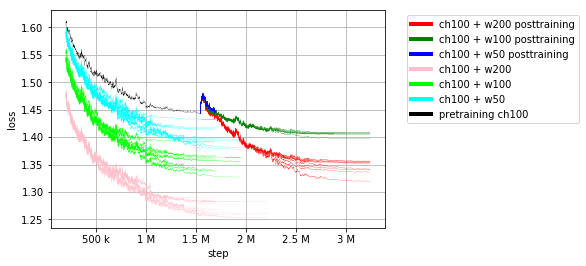

In [34]:
print(groups_of_file_names.keys())

main(
    groups_of_file_names,
    {'pretraining ch100': os.path.join(prefix, 'loss_pretrain.txt')},
    ['red', 'green', 'blue', 'pink', 'lime', 'cyan'],
    ['black'],
    0.2,
    'step',
    'loss',
    'linear',
    'linear',
    mpl.ticker.EngFormatter(),
    200,
    'outside',
    900,
    os.path.join(prefix, 'plots/pre_and_post_training.png'),
    True
)

In [7]:
import pickle
from collections import OrderedDict


def load_pickle(file_name):
    values = []
    with open(file_name, 'rb') as f:
        while True:
            try:
                values.append(pickle.load(f))
            except EOFError:
                break
    return values


prefix = '/media/anton/DATA/results/h-elmo/expres/entropy/first_experiment/hist'
path = 'tensors/valid/accumulator_postprocessing'
dirs = [str(i) for i in range(3)]
layers = ['level0_0', 'level0_1']
labels = OrderedDict([('level0_0', 'char encoder'), ('level0_1', 'char decoder')])

entropy_tmpl = 'mean_entropy_{}_hidden_state.pickle'
mi_tmpl = 'mean_mi_{}_hidden_state.pickle'

path_to_loss = os.path.join(prefix, '0/results/loss_valid.txt')

def get_steps(fn):
    steps = []
    with open(fn) as f:
        for line in f.readlines():
            step = int(line.split()[0])
            steps.append(step)
    return steps

steps = get_steps(path_to_loss)
        
entropy_lines = OrderedDict(zip(labels.values(), [[] for _ in layers]))
mi_lines = OrderedDict(zip(labels.values(), [[] for _ in layers]))

for d in dirs:
    for layer in layers:
        entropy_fn = entropy_tmpl.format(layer)
        entropy_fn = os.path.join(prefix, d, path, entropy_fn)
        mi_fn = mi_tmpl.format(layer)
        mi_fn = os.path.join(prefix, d, path, mi_fn)
        label = labels[layer]
        entropy_lines[label].append([steps, load_pickle(entropy_fn)])
        mi_lines[label].append([steps, load_pickle(mi_fn)])


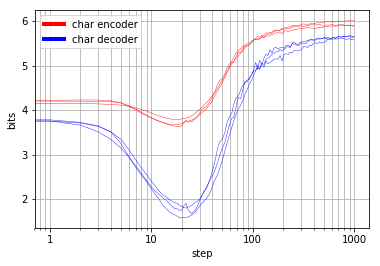

In [8]:
save_path = os.path.join(prefix, 'plots/entropy.png')

plot_groups_of_lines(
    entropy_lines,
    {},
    ['red', 'blue'],
    [],
    0.4,
    'step',
    'bits',
    'log',
    'linear',
    mpl.ticker.ScalarFormatter(),
    0,
    'best',
    900,
    save_path,
    True,
)

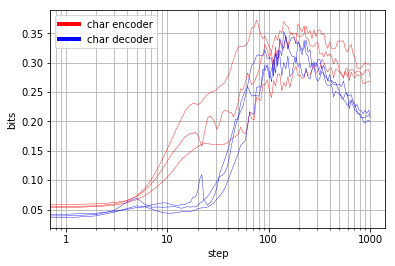

In [9]:
save_path = os.path.join(prefix, 'plots/mi.png')

plot_groups_of_lines(
    mi_lines,
    {},
    ['red', 'blue'],
    [],
    0.4,
    'step',
    'bits',
    'log',
    'linear',
    mpl.ticker.ScalarFormatter(),
    0,
    'best',
    900,
    save_path,
    True,
)

In [20]:
import pickle
from collections import OrderedDict


def load_pickle(file_name):
    values = []
    with open(file_name, 'rb') as f:
        while True:
            try:
                values.append(pickle.load(f))
            except EOFError:
                break
    return values


prefix = '/media/anton/DATA/results/h-elmo/expres/correlation/nocorrloss/wide'
path = 'tensors/valid/pickle_mean_tensors/mean_sqr_correlation.pickle'
dirs = [str(i) for i in range(3)]
dropout = ['0', '0.2', '0.4', '0.7']
labels = OrderedDict([('0', 'dropout 0'), ('0.2', 'dropout 0.2'), ('0.4', 'dropout 0.4'), ('0.7', 'dropout 0.7')])

path_to_loss = os.path.join(prefix, '0/0/results/loss_valid.txt')

def get_steps(fn):
    steps = []
    with open(fn) as f:
        for line in f.readlines():
            step = int(line.split()[0])
            steps.append(step)
    return steps

steps = get_steps(path_to_loss)
print(steps)
        
correlation_lines = OrderedDict(zip(labels.values(), [[] for _ in dropout]))

for d in dirs:
    for dp in dropout:
        correlation_fn = os.path.join(prefix, dp, d, path)
        label = labels[dp]
        y = load_pickle(correlation_fn)[0]
        print(y.shape)
        correlation_lines[label].append([steps, y])
a = correlation_lines['dropout 0.4'][0][1]
# correlation_lines['dropout 0.4'][0][1] = np.concatenate([a[:64], a[65:]])
# m = float('inf')
# for i in range(100):
#     if abs(a[i] - a[i+1]) < m:
#         m = abs(a[i] - a[i+1])
#         j = i
# print(j, abs(a[j] - a[j+1]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 40, 43, 46, 49, 52, 55, 58, 62, 66, 70, 74, 79, 84, 89, 94, 100, 106, 112, 119, 126, 133, 141, 149, 158, 167, 177, 187, 198, 209, 221, 234, 247, 261, 276, 292, 308, 325, 343, 362, 382, 403, 425, 449, 474, 500, 528, 557, 588, 621, 655, 691, 729, 769, 811, 856, 903, 953, 1005, 1060, 1118, 1179, 1244, 1312, 1384, 1460, 1540, 1624, 1713, 1807, 1906, 2000]
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)


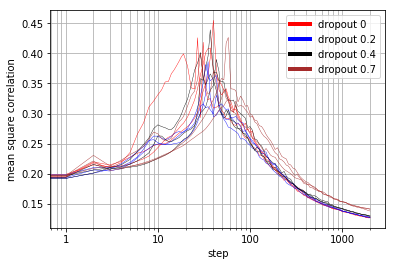

In [21]:
save_path = os.path.join(prefix, 'plots/mean_sqr_correlation_bundles.png')

plot_groups_of_lines(
    correlation_lines,
    {},
    ['red', 'blue', 'black', 'brown'],
    [],
    0.4,
    'step',
    'mean square correlation',
    'log',
    'linear',
    mpl.ticker.ScalarFormatter(),
    0,
    'best',
    900,
    save_path,
    True,
)

In [25]:
import pickle
from collections import OrderedDict


def load_pickle(file_name):
    values = []
    with open(file_name, 'rb') as f:
        while True:
            try:
                values.append(pickle.load(f))
            except EOFError:
                break
    return values


prefix = '/home/anton/h-elmo/expres/correlation/nocorrloss/sgd'
path = 'tensors/valid/pickle_mean_tensors/correlation.pickle'
dirs = [str(i) for i in range(3)]

path_to_loss = os.path.join(prefix, '0/results/loss_valid.txt')

def get_steps(fn):
    steps = []
    with open(fn) as f:
        for line in f.readlines():
            step = int(line.split()[0])
            steps.append(step)
    return steps

steps = get_steps(path_to_loss)
print(steps)
        
correlation_lines = OrderedDict(zip(['sgd'], [[]]))

for d in dirs:
    correlation_fn = os.path.join(prefix, d, path)
    label = 'sgd'
    y = load_pickle(correlation_fn)
    y = [yy**0.5 for yy in y]
    correlation_lines[label].append([steps, y])
# correlation_lines['dropout 0.4'][0][1] = np.concatenate([a[:64], a[65:]])
# m = float('inf')
# for i in range(100):
#     if abs(a[i] - a[i+1]) < m:
#         m = abs(a[i] - a[i+1])
#         j = i
# print(j, abs(a[j] - a[j+1]))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 40, 43, 46, 49, 52, 55, 58, 62, 66, 70, 74, 79, 84, 89, 94, 100, 106, 112, 119, 126, 133, 141, 149, 158, 167, 177, 187, 198, 209, 221, 234, 247, 261, 276, 292, 308, 325, 343, 362, 382, 403, 425, 449, 474, 500, 528, 557, 588, 621, 655, 691, 729, 769, 811, 856, 903, 953, 1005, 1060, 1118, 1179, 1244, 1312, 1384, 1460, 1540, 1624, 1713, 1807, 1906, 2000]


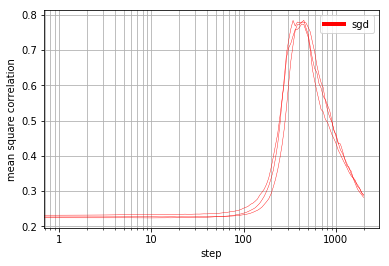

In [26]:
save_path = os.path.join(prefix, 'plots/mean_sqr_correlation_bundles.png')

plot_groups_of_lines(
    correlation_lines,
    {},
    ['red', 'blue', 'black', 'brown'],
    [],
    0.4,
    'step',
    'mean square correlation',
    'log',
    'linear',
    mpl.ticker.ScalarFormatter(),
    0,
    'best',
    900,
    save_path,
    True,
)

In [14]:
import numpy as np

a = np.int32(2*10**9)
b = np.int32(10**9)
print(a+b)

-1294967296


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in int_scalars
  """


In [ ]:
for i in range(3):
  for layer in ['level0_0', 'level0_1']:
    fn = tmpl.format(i, layer)
    values = load_pickle(fn)
    m = [np.min(v) for v in values]
    for mm in m:
      if mm < 0:
        print(mm)

In [ ]:
for d in {0..2}; do for l in "${layers[@]}"; do python3 $SCRIPTS/hist2entropy.py ${d}/${path}/hist_fixed^C{l}_hidden_state.pickle ${d}/${path}/entropy_${l}_hidden_state.pickle;     python3 $SCRIPTS/hist2mi.py ${d}/${path}/hist_fixed_${l}_hidden_state.pickle ${d}/${path}/cross_hist_fixed_${l}_hidden_state.pickle ${d}/${path}/mi_${l}_hidden_state.pickle; done; done

In [2]:
from sympy.solvers import solve
from sympy import *

a, x = symbols('a x')
sol = solve(0.5*x-0.25*sin(2*x)-a, x)

print(sol)

NotImplementedError: multiple generators [x, sin(2*x)]
No algorithms are implemented to solve equation -a + x/2 - sin(2*x)/4

In [6]:
!pip install --upgrade pip

  Using cached https://files.pythonhosted.org/packages/62/ca/94d32a6516ed197a491d17d46595ce58a83cbb2fca280414e57cd86b84dc/pip-19.2.1-py2.py3-none-any.whl
  Found existing installation: pip 19.1.1
    Uninstalling pip-19.1.1:
      Successfully uninstalled pip-19.1.1


In [61]:
hidden_sizes = sample_hidden_sizes(321600, 0.9, 4, 100, 100)
print(len(hidden_sizes))
for hs in hidden_sizes:
    print(sum(hs))
print(hidden_sizes)

100
398
366
361
364
387
377
360
400
393
401
361
359
384
370
362
395
401
400
386
392
360
383
404
404
389
400
370
394
354
386
367
403
381
378
360
392
363
338
402
350
391
381
395
402
404
384
388
378
399
351
369
393
391
405
364
374
392
400
403
405
399
380
408
389
403
376
390
394
395
392
395
380
403
352
399
351
405
395
374
394
392
398
397
358
375
390
338
385
390
386
399
404
386
360
400
385
375
400
402
367
[[33, 110, 50, 205], [32, 99, 177, 58], [104, 133, 104, 20], [62, 40, 209, 53], [45, 97, 146, 99], [34, 165, 111, 67], [108, 169, 33, 50], [107, 55, 60, 178], [140, 79, 81, 93], [113, 126, 28, 134], [119, 141, 65, 36], [140, 132, 36, 51], [122, 16, 176, 70], [135, 128, 46, 61], [187, 53, 38, 84], [102, 117, 88, 88], [73, 90, 117, 121], [131, 52, 89, 128], [74, 51, 44, 217], [40, 100, 129, 123], [72, 73, 196, 19], [163, 32, 121, 67], [65, 170, 25, 144], [27, 157, 40, 180], [140, 31, 141, 77], [126, 82, 32, 160], [57, 52, 196, 65], [122, 30, 73, 169], [59, 186, 83, 26], [113, 55, 157, 61], [

In [53]:
def get_num_lstm_param(input_size, hidden_size):
    num_param = (input_size+hidden_size) * (4*hidden_size) + 4*hidden_size
    return num_param


def get_num_multi_lstm_param(input_size, hidden_sizes):
    num_param = 0
    for hs in hidden_sizes:
        num_param += get_num_lstm_param(input_size, hs)
        input_size = hs
    return num_param

In [54]:
for hs in hidden_sizes:
    print(hs, get_num_multi_lstm_param(100, hs))

[135, 19, 189, 27] 320660
[103, 106, 124, 49] 321768
[84, 142, 99, 57] 322724
[27, 195, 98, 35] 321772
[51, 116, 44, 193] 321032
[148, 33, 153, 45] 321696
[126, 73, 114, 80] 320936
[54, 75, 148, 111] 320528
[68, 39, 204, 56] 320384
[90, 100, 114, 94] 321784
[91, 140, 50, 120] 320088
[44, 68, 155, 116] 321344
[119, 45, 69, 166] 322864
[45, 88, 166, 79] 320504
[18, 208, 82, 53] 321712
[40, 221, 21, 97] 320752
[157, 27, 125, 78] 322152
[73, 129, 94, 103] 321356
[129, 84, 114, 58] 321464
[123, 118, 41, 114] 321808
[47, 159, 81, 109] 320836
[94, 93, 67, 153] 321656
[74, 124, 136, 42] 322560
[67, 194, 60, 30] 320456
[47, 136, 93, 124] 321608
[142, 85, 96, 58] 321392
[60, 188, 56, 76] 321200
[151, 72, 105, 49] 321860
[156, 77, 39, 115] 321992
[102, 48, 160, 79] 321416
[53, 146, 16, 193] 322000
[137, 14, 71, 166] 321392
[28, 106, 156, 87] 320712
[122, 19, 174, 69] 321984
[27, 88, 53, 218] 321944
[143, 124, 16, 93] 322440
[105, 135, 32, 130] 322924
[57, 68, 195, 47] 321900
[118, 82, 71, 132] 32

In [27]:
!python3 -m pip install --upgrade pip

  Using cached https://files.pythonhosted.org/packages/62/ca/94d32a6516ed197a491d17d46595ce58a83cbb2fca280414e57cd86b84dc/pip-19.2.1-py2.py3-none-any.whl
  Found existing installation: pip 19.1.1
    Uninstalling pip-19.1.1:
      Successfully uninstalled pip-19.1.1


In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__version__)
%matplotlib notebook

points = []
for _ in range(1000):
    p = sample_point_from_sum_triangle(100, 4, 1)
    if any([c < 0 for c in p]):
        print('Error!', p)
        break
#     points.append(p)
    
# x, y, z = zip(*points)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z)
# plt.show()

3.0.3


3.0.3
[-0.1178232637627934, 0.11729648649974234, -0.034301746109729914]
[0.2088657892428476, 0.2634138340945724, -0.16897193363871432]
[0.1831332757374151, -0.38326409108929016, -0.3609453188266978]
[-0.3739730967599819, 0.17517079233679334, -0.33944728803425406]
[-0.2938365424682754, -0.2220484956192359, 0.09540450039832016]
[0.25933813395577676, 0.008463944497584475, -0.15673888368934596]
[-0.5978200048573936, 0.36591477351634305, -0.5790540878040897]
[0.19994979810016877, -0.11426350270694652, -0.06066832414081036]
[0.4102175818394984, 0.13388043371253588, 0.02349408168397238]
[-0.2165172369270829, -0.3981772118917617, -0.2923219426321104]
[0.9351284502729484, -0.005586627220860008, 0.029565183563459607]
[-0.4540119804288827, -0.6022658134496359, 0.16010395053934312]
[-0.28676781737502255, 0.24415111531809752, -0.40500192300695814]
[-0.37411017966333593, 0.15769252524859279, -0.4285537933597765]
[0.23055015217451857, -0.2994626521705197, -0.22606389371521085]
[-0.1329468265464877, 0

<IPython.core.display.Javascript object>


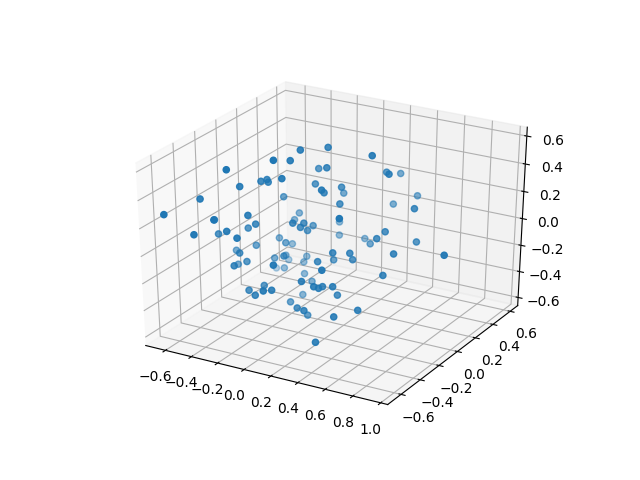

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__version__)
%matplotlib notebook

points = []
for _ in range(100):
    p = sample_point_from_sum_prism(3, 1)
    print(p)
    points.append(p)
    
x, y, z = zip(*points)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
plt.show()

In [ ]:
points = sample_shifted_points_inside_sphere_with_constant_sum(
    [100, 100, 100],
    
)

In [19]:
print(sum([9.346068550516723, -0.49577868439307227, 36.18069694773759, 54.96901318613876]))

100.0


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

psi_values = [sample_psi() for _ in range(100000)]
plt.hist(psi_values, bins=1000)
plt.show()

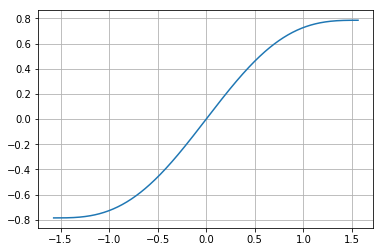

In [19]:
import math

%matplotlib inline
import matplotlib.pyplot as plt


range_ = [-math.pi / 2, math.pi / 2]
d = (range_[1] - range_[0]) / 400
x = [range_[0] + d * i for i in range(400)]
y = [0.5 * (xx + 0.5*math.sin(2*xx)) for xx in x]

plt.plot(x, y)
plt.grid()
plt.show()

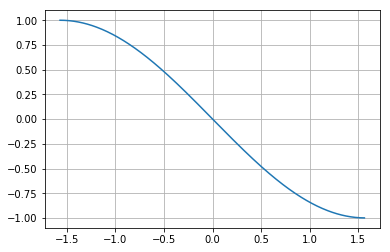

In [12]:
import math

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

range_ = [-math.pi / 2, math.pi / 2]
d = (range_[1] - range_[0]) / 400
x = [range_[0] + d * i for i in range(400)]
y = [-np.sin(xx) for xx in x]

plt.plot(x, y)
plt.grid()
plt.show()

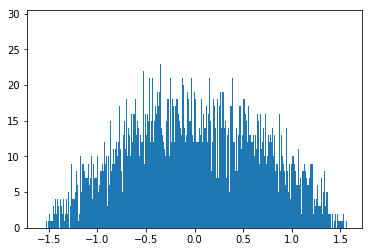

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

theta_values = [sample_theta() for _ in range(10000)]
plt.hist(theta_values, bins=1000)
plt.show()

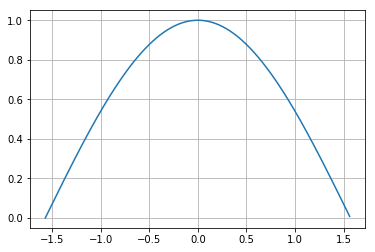

In [13]:
import math

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

range_ = [-math.pi / 2, math.pi / 2]
d = (range_[1] - range_[0]) / 400
x = [range_[0] + d * i for i in range(400)]
y = [np.cos(xx) for xx in x]

plt.plot(x, y)
plt.grid()
plt.show()

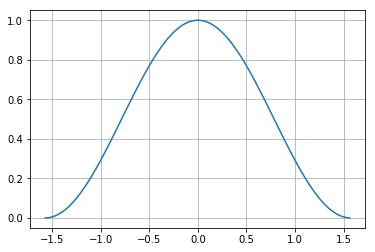

In [15]:
import math

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

range_ = [-math.pi / 2, math.pi / 2]
d = (range_[1] - range_[0]) / 400
x = [range_[0] + d * i for i in range(400)]
y = [np.cos(xx)**2 for xx in x]

plt.plot(x, y)
plt.grid()
plt.show()

In [16]:
import random
import timeit

t1 = timeit.timeit(
    stmt="random.uniform(0,1)",
    number=1000,
    globals=dict(random=random),
)
t2 = timeit.timeit(
    stmt="random.uniform(0,100)",
    number=1000,
    globals=dict(random=random),
)
print(t1, t2)

0.0003801872953772545 0.00037553906440734863


In [80]:
def log_net(start, end, factor):
    net = []
    while start < end:
        net.append(start)
        start *= factor
        r_start = round(start)
        if r_start <= start:
            r_start = r_start+1
        r_start = int(r_start)
        start = r_start
    net.append(end)
    return net
    
    
net = log_net(0, 2000, 1.0545)
print(len(net))
print(net)

100
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 40, 43, 46, 49, 52, 55, 58, 62, 66, 70, 74, 79, 84, 89, 94, 100, 106, 112, 119, 126, 133, 141, 149, 158, 167, 177, 187, 198, 209, 221, 234, 247, 261, 276, 292, 308, 325, 343, 362, 382, 403, 425, 449, 474, 500, 528, 557, 588, 621, 655, 691, 729, 769, 811, 856, 903, 953, 1005, 1060, 1118, 1179, 1244, 1312, 1384, 1460, 1540, 1624, 1713, 1807, 1906, 2000]


In [9]:
from learning_to_learn.controller import Controller

spec = {
    "type": "logarithmic_truth",
    "start": 0,
    "factor": 1.02,
    "end": 1000,
}

storage = {'step': 0}

controller = Controller(storage, spec)

count = 0
for _ in range(1000):
    if controller.get():
        count += 1
        # print(storage['step'])
    storage['step'] += 1
print(count)

206


In [2]:
from collections import OrderedDict


def parse_pos_corr_table(table_file_name, layer_names):
    with open(table_file_name) as f:
        table_text = f.read()
    text_by_tags = table_text.split('\n')
    text_by_tags = [line for line in text_by_tags if line]
    data = OrderedDict(zip(layer_names, [[[], [], []] for _ in layer_names]))
    for i, line in enumerate(text_by_tags):
        values_and_errors = line.split(';')
        for layer_name, vne in zip(layer_names, values_and_errors):
            v, e = vne.split(' ± ')
            v = float(v)
            e = float(e)
            data[layer_name][0].append(i)
            data[layer_name][1].append(v)
            data[layer_name][2].append(e)
    return data


data = parse_pos_corr_table(
    'expres/resrnn/poscorr/4/tables/table.csv',
    ['char encoder', 'char decoder', 'word encoder', 'word decoder'],
)
print(data)

OrderedDict([('char encoder', [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], [0.098, 0.158, 0.089, 0.22, 0.168, 0.128, 0.153, 0.066, 0.07, 0.106, 0.108, 0.0412, 0.042, 0.162, 0.066, 0.11, 0.064, 0.041, 0.053, 0.05, 0.042, 0.031, 0.0267, 0.0216, 0.0259, 0.0327, 0.031], [0.007, 0.007, 0.003, 0.01, 0.006, 0.008, 0.008, 0.003, 0.004, 0.005, 0.003, 0.0013, 0.002, 0.003, 0.003, 0.005, 0.003, 0.002, 0.002, 0.003, 0.003, 0.002, 0.0013, 0.0016, 0.0013, 0.0015, 0.002]]), ('char decoder', [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], [0.118, 0.154, 0.088, 0.218, 0.13, 0.13, 0.13, 0.0548, 0.06, 0.088, 0.084, 0.06, 0.043, 0.15, 0.063, 0.067, 0.057, 0.043, 0.049, 0.049, 0.028, 0.036, 0.0195, 0.019, 0.024, 0.03, 0.038], [0.008, 0.005, 0.004, 0.015, 0.01, 0.01, 0.01, 0.0015, 0.005, 0.007, 0.006, 0.01, 0.002, 0.006, 0.005, 0.004, 0.003, 0.004, 0.004, 0.003, 0.002, 0.004, 0.0016, 0.002, 0.002, 0.

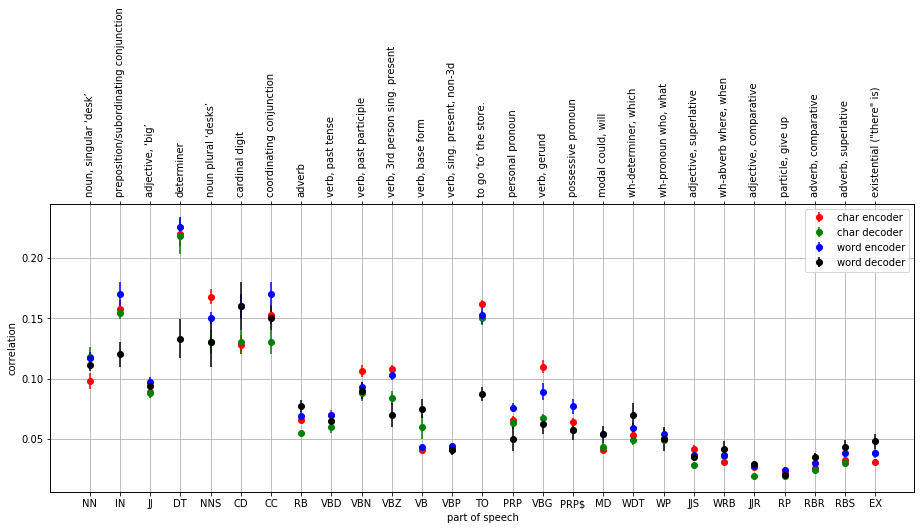

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt


def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)


def mark_x_axis(tags):
    n = len(tags)
    plt.xticks(range(n))
    set_size(12, 4)
    plt.gca().set_xticklabels(tags)


def read_tags(tag_file_name):
    with open(tag_file_name) as f:
        tags = f.readlines()
    return [t.strip() for t in tags]


def add_upper_x_axis(upper_tags):
    xlim = plt.xlim()
    secax = plt.twiny()
    secax.set_xlim(*xlim)
    secax.set_xticks(range(len(upper_tags)))
    secax.set_xticklabels(upper_tags, rotation='vertical')


def tag_plot(data, tags, colors, markers, xlabel, ylabel, upper_tags=None):
    _, ax = plt.subplots()
    for (label, dt), color, mk in zip(data.items(), colors, markers):
        ax.errorbar(dt[0], dt[1], yerr=dt[2], color=color, marker=mk, label=label, linestyle=' ')
    mark_x_axis(tags)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if upper_tags is not None:
        add_upper_x_axis(upper_tags)
    ax.grid()
    ax.legend(loc='best')


tags = read_tags('dataset_tags/text8_first6.4e5_tags.txt')
upper_tags = read_tags('dataset_tags/text8_first6.4e5_tag_description.txt')
n = len(data['char encoder'][0])
tag_plot(
    data,
    tags[:n],
    ['red', 'green', 'blue', 'black'],
    ['o', 'o', 'o', 'o'],
    'part of speech',
    'correlation',
    upper_tags=upper_tags[:n],
)
plt.show()


In [12]:
!python3.6 -m pip install --upgrade matplotlib

Requirement already up-to-date: matplotlib in /home/anton/dpenv/lib/python3.6/site-packages (3.1.1)
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

print(mpl.__version__)
fig, ax = plt.subplots()
print(type(ax))
attributes = dir(ax)
for m in attributes:
    if 'secondary' in m:
        print(m)

3.0.3
<class 'matplotlib.axes._subplots.AxesSubplot'>


In [22]:
help(list)

Help on class list in module builtins:

class list(object)
 |  list() -> new empty list
 |  list(iterable) -> new list initialized from iterable's items
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(...)
 |      x.__getitem__(y) <==> x[y]
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __iadd__(self, value, /)
 |      Implement self+=value.
 |  
 |  __imul__(self, value, /)
 |      Implement self*=value.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __l